In [1]:
# Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
df = pd.read_csv('train.csv', usecols = ['text', 'target'])
# Se agrega un columna para la longitud del mensaje.
df['length'] = df['text'].str.len()
# Se informan las mediciones pedidas.
print('Características de longitud del texto del mensaje')
print('Máxima:', df['length'].max(), \
'\tMínina:', df['length'].min(), \
'\tMedia:', np.round(df['length'].mean(), decimals = 0))

Características de longitud del texto del mensaje
Máxima: 157 	Mínina: 7 	Media: 101.0


In [3]:
# Se arma nuevo DataFrame agrupando por longitud de mensaje
join = pd.DataFrame()
join['is_true'] = df.groupby('length')['target'].agg('sum')
join['total'] = df.groupby('length')['target'].agg('count')
join['portion_is_true'] = round(join['is_true'] / join['total'], 3)
# Se quitan los casos extremos.
clean = join.loc[join['portion_is_true'] < 1]
display(clean.nlargest(5, 'portion_is_true'))
print('Promedio de las cinco longitudes con mejor índice de veracidad:', \
clean.nlargest(5, 'portion_is_true').index.values.mean())
print('Mediana de las cinco longitudes con mejor índice de veracidad:', \
np.median(clean.nlargest(5, 'portion_is_true').index.values))

,is_true,total,portion_is_true
length,,,
136,277,401,0.691
91,60,88,0.682
135,119,191,0.623
116,40,67,0.597
137,125,210,0.595


Promedio de las cinco longitudes con mejor índice de veracidad: 123.0
Mediana de las cinco longitudes con mejor índice de veracidad: 135.0


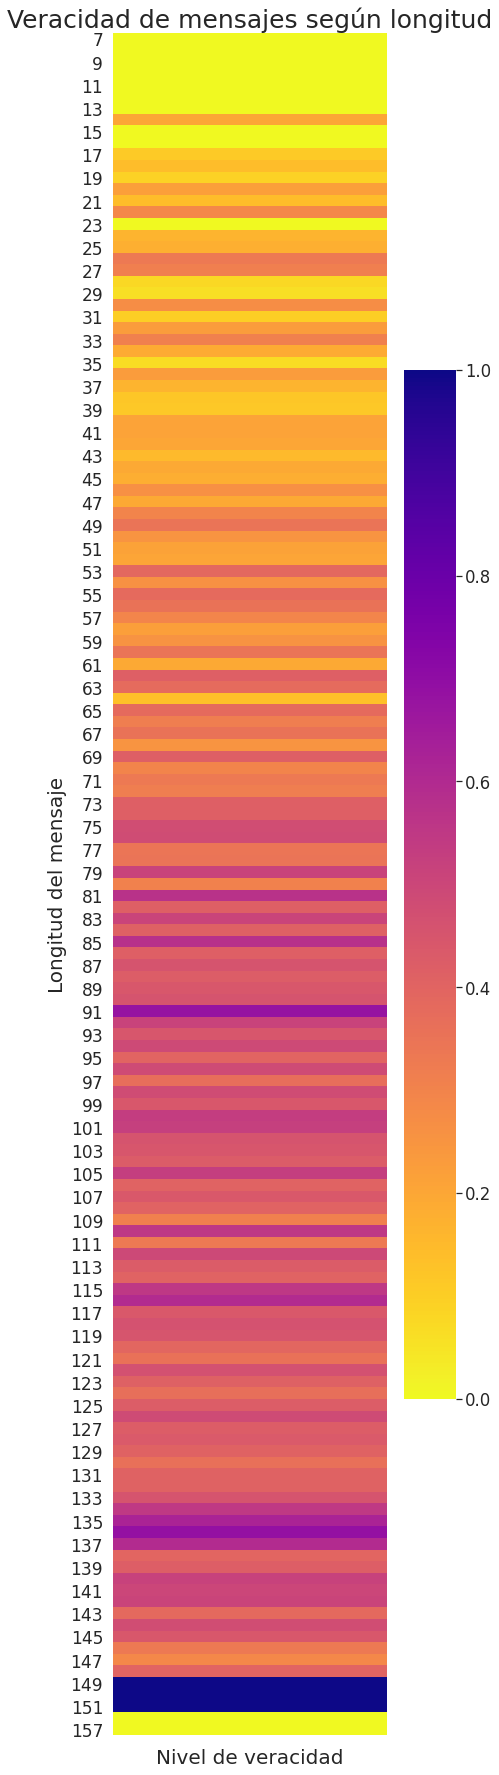

In [4]:
# Plot
plt.figure(figsize = (7,25))
sb.set(font_scale = 1.5)
plot = sb.heatmap(join[['portion_is_true']], cmap = 'plasma_r', \
cbar = True, xticklabels = [''])
plt.title('Veracidad de mensajes según longitud',fontsize = 25)
plot.set_xlabel('Nivel de veracidad', fontsize = 20)
plot.set_ylabel('Longitud del mensaje', fontsize = 20)
plt.xticks(fontsize = 17, rotation = 0, ha = 'center', va = 'top')
plt.yticks(fontsize = 17, rotation = 0)
plt.tight_layout() # Para que no recorte los títulos.
plt.show()